In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configuration
BATCH_SIZE = 64
IMG_SIZE = (224, 224)  # Original image size
EPOCHS = 30

2025-06-05 16:08:36.685871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749139716.874256      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749139716.927634      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define paths
base_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images'
train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'validation')
test_dir = os.path.join(base_path, 'test')

# Get class names
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test generators (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [3]:
def create_cnn_model():
    model = models.Sequential([
        # First Conv Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Conv Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Conv Block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

model = create_cnn_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749139871.913424      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749139871.914123      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 103,919,695 (396.42 MB)

 Trainable params: 103,916,879 (396.41 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [4]:
# Optimizer with learning rate schedule
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = optimizers.Adam(learning_rate=lr_schedule)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Fix the learning rate schedule issue
initial_learning_rate = 1e-3
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9
)

# 2. Simplified model compilation
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule),  # Fixed learning rate assignment
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# 3. Enhanced callbacks
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# 4. Proper training with fixed steps calculation
history = model.fit(
    train_generator,
    steps_per_epoch=min(200, train_generator.samples // BATCH_SIZE),  # Safety cap
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=30,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.8890 - auc: 0.9913 - loss: 0.3530 - val_accuracy: 0.6627 - val_auc: 0.9173 - val_loss: 1.6672 - learning_rate: 9.9790e-04
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 208ms/step - accuracy: 0.9211 - auc: 0.9944 - loss: 0.2490 - val_accuracy: 0.8747 - val_auc: 0.9862 - val_loss: 0.4420 - learning_rate: 9.9753e-04
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 187s 933ms/step - accuracy: 0.9295 - auc: 0.9966 - loss: 0.2191 - val_accuracy: 0.8865 - val_auc: 0.9883 - val_loss: 0.4084 - learning_rate: 9.9543e-04
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 192ms/step - accuracy: 0.9487 - auc: 0.9961 - loss: 0.1864 - val_accuracy: 0.8675 - val_auc: 0.9876 - val_loss: 0.4560 - learning_rate: 9.9506e-04
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 186s 926ms/step - accuracy: 0.9413 - auc: 0.9968 - loss: 0.1840 - val_accuracy: 0.8964 - val_auc: 0.9888 - val_loss: 0.3770 - learning_rate: 9.9297e-04
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 43s 2

TypeError: This optimizer was created with a `LearningRateSchedule` object as its `learning_rate` constructor argument, hence its learning rate is not settable. If you need the learning rate to be settable, you should instantiate the optimizer with a float `learning_rate` argument.

In [8]:
# Evaluate model on test data
test_loss, test_accuracy, test_auc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test AUC: {test_auc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 973ms/step - accuracy: 0.8018 - auc: 0.9614 - loss: 0.9440
Test Accuracy: 84.90%
Test AUC: 0.9755


Found 3000 images belonging to 15 classes.


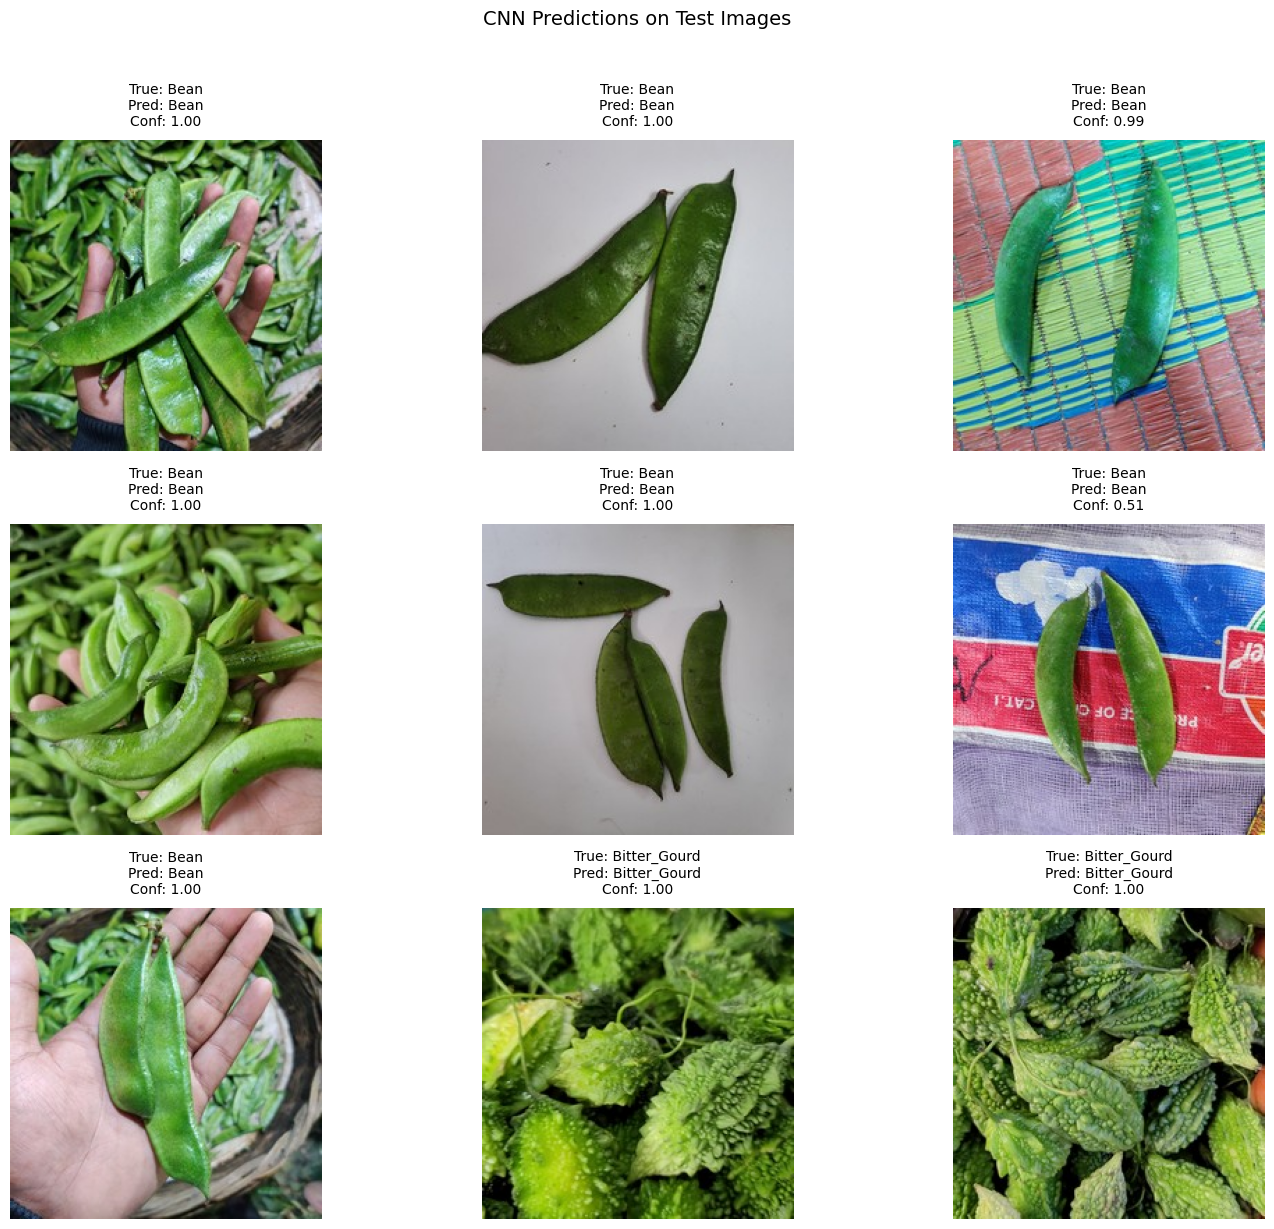


Generating confusion matrix...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step


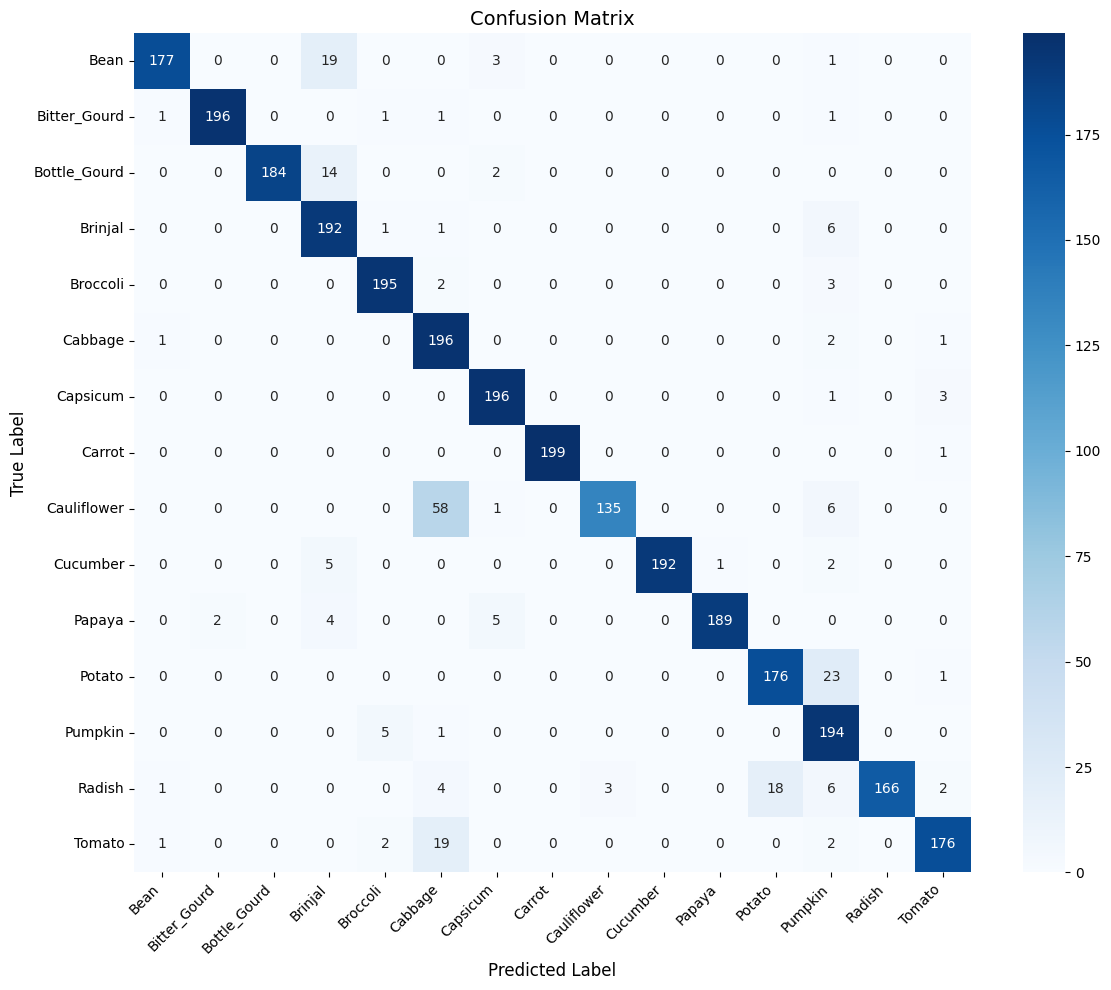


Classification Report:
              precision    recall  f1-score   support

        Bean       0.98      0.89      0.93       200
Bitter_Gourd       0.99      0.98      0.98       200
Bottle_Gourd       1.00      0.92      0.96       200
     Brinjal       0.82      0.96      0.88       200
    Broccoli       0.96      0.97      0.97       200
     Cabbage       0.70      0.98      0.81       200
    Capsicum       0.95      0.98      0.96       200
      Carrot       1.00      0.99      1.00       200
 Cauliflower       0.98      0.68      0.80       200
    Cucumber       1.00      0.96      0.98       200
      Papaya       0.99      0.94      0.97       200
      Potato       0.91      0.88      0.89       200
     Pumpkin       0.79      0.97      0.87       200
      Radish       1.00      0.83      0.91       200
      Tomato       0.96      0.88      0.92       200

    accuracy                           0.92      3000
   macro avg       0.93      0.92      0.92      3000
we

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Load your trained model
model = tf.keras.models.load_model('/kaggle/working/best_model.h5')  # Update path if needed

# 2. Prepare test data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/vegetable-image-dataset/Vegetable Images/test',
    target_size=(224, 224),
    batch_size=32,  # Smaller batch for visualization
    class_mode='categorical',
    shuffle=False  # Important for consistent results
)

# Get class names
class_names = list(test_generator.class_indices.keys())

# 3. Reset generator before visualization
test_generator.reset()

# 4. Create the prediction visualization
plt.figure(figsize=(15, 12))
for i in range(9):  # 3x3 grid
    plt.subplot(3, 3, i+1)
    
    # Get next batch - correct method for TF 2.x
    batch = next(test_generator)
    img, label = batch[0][0:1], batch[1][0:1]  # Take just first image from batch
    
    # Make prediction
    pred_prob = model.predict(img, verbose=0)[0]
    true_class = class_names[np.argmax(label)]
    pred_class = class_names[np.argmax(pred_prob)]
    confidence = np.max(pred_prob)
    
    # Display image and results
    plt.imshow(img[0])
    plt.title(f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}", 
              fontsize=10, pad=10)
    plt.axis('off')

plt.suptitle('CNN Predictions on Test Images', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('predictions_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Additional: Show confusion matrix (optional)
print("\nGenerating confusion matrix...")
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

In [17]:
import tensorflow as tf
import pandas as pd

# 1. Save the final model (ensure model is defined)
model.save('vegetable_cnn_model.h5')

# 2. Convert to TFLite (optional)
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open('vegetable_model.tflite', 'wb') as f:
        f.write(tflite_model)
    print("TFLite model saved successfully!")
except Exception as e:
    print(f"Error converting to TFLite: {e}")

# 3. Save training history (only if history exists)
try:
    if 'history' in globals():  # Check if history variable exists
        history_df = pd.DataFrame(history.history)
        history_df.to_csv('training_history.csv', index=False)
        print("Training history saved successfully!")
    else:
        print("No training history found to save")
except Exception as e:
    print(f"Error saving training history: {e}")

print("\nAll operations completed!")

Saved artifact at '/tmp/tmpf653km9q'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  133265227854096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133265227847760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133264859971664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133264859972624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133265227851216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133265227853712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133264859973008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133264859974352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133264859973776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133264859974928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13326485997358

W0000 00:00:1749147771.457764      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749147771.457808      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


TFLite model saved successfully!
No training history found to save

All operations completed!


In [19]:
import zipfile
import os
from IPython.display import FileLink

# Create zip
files_to_zip = [
    'vegetable_cnn_model.h5',
    'vegetable_model.tflite',
    'training_history.csv'
]

with zipfile.ZipFile('model_artifacts.zip', 'w') as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file)

# Create download link
FileLink('model_artifacts.zip')

/kaggle/working/model_artifacts.zip